In [107]:
import os
import sys
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import nltk

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, \
                        Flatten, MaxPooling1D, GRU, SpatialDropout1D, Bidirectional, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

# Import data and Preprocess

In [7]:
df = pd.read_csv('labeledTrainData.tsv', sep='\t')
df.shape

(25000, 3)

In [8]:
df.head()

,id,sentiment,review
0,5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \""critics\"" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \""critics\"". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \""critics\"" perceive to be its shortcomings."""
2,7759_3,0,"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security

In [10]:
# function to clean strings 
def clean_str(string):
    """
    string cleaning for dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

texts = []
labels = []

# remove html tags
for idx in range(df.review.shape[0]):
    text = BeautifulSoup(df.review[idx])
    texts.append(clean_str(text.get_text()))
    labels.append(df.sentiment[idx])

In [13]:
texts[0]

'with all this stuff going down at the moment with mj ive started listening to his music, watching the odd documentary here and there, watched the wiz and watched moonwalker again. maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. some of it has subtle messages about mjs feeling towards the press and also the obvious message of drugs are bad mkay.visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring. some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him.the actual feature film bit when it finally starts is only on for 20 minut

In [27]:
# find maximum number of words in texts
max([len(text.split()) for text in texts])

2450

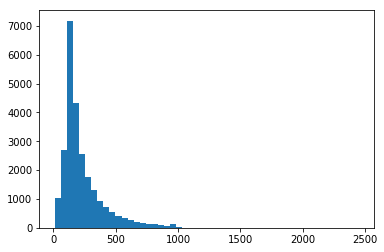

In [36]:
# distribution of number of words
plt.hist([len(text.split()) for text in texts], bins=50)
plt.show()

Seems maximum sequence length of 1000 is good.

In [41]:
# find total number of unique words
len(set(" ".join([text for text in texts]).split()))

239101

In [42]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [43]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [47]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 81501 unique tokens.


In [49]:
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000, 2)


In [53]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=VALIDATION_SPLIT, random_state=0)

In [52]:
print(X_train.shape)
print(y_train.shape)

(20000, 1000)
(20000, 2)


In [55]:
print('Number of positive and negative reviews in traing and validation set ')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set 
[ 9952. 10048.]
[2548. 2452.]


In [58]:
GLOVE_100D = '/Users/rameda/Downloads/python/glove.6B/glove.6B.100d.txt'

In [59]:
# get word embeddings
embeddings_index = {}
f = open(GLOVE_100D)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [60]:
# get word embeddings for the words in dataset
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [61]:
embedding_matrix.shape

(81502, 100)

# Embedding Layer

In [99]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            name='embedding')

# CNN model

In [100]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input')
embedded_sequences = embedding_layer(sequence_input)

l_cov1 = Conv1D(128, 5, activation='relu', name='conv1d_1')(embedded_sequences)
l_pool1 = MaxPooling1D(5, name='pool_1')(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu', name='conv1d_2')(l_pool1)
l_pool2 = MaxPooling1D(5, name='pool_2')(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu', name='conv1d_3')(l_pool2)
l_pool3 = MaxPooling1D(35, name='pool_3')(l_cov3)  # global max pooling
l_flat = Flatten(name='flatten')(l_pool3)
l_dense = Dense(128, activation='relu', name='dense')(l_flat)
preds = Dense(2, activation='softmax', name='softmax')(l_dense)

In [101]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [102]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         8150200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

In [104]:
# fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=10, batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.6713 - acc: 0.6228 - val_loss: 1.4216 - val_acc: 0.5022
Epoch 2/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.4997 - acc: 0.7669 - val_loss: 0.4416 - val_acc: 0.7932
Epoch 3/10
20000/20000 [==============================] - 94s 5ms/step - loss: 0.4139 - acc: 0.8165 - val_loss: 0.3571 - val_acc: 0.8422
Epoch 4/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.3668 - acc: 0.8371 - val_loss: 0.4057 - val_acc: 0.8172
Epoch 5/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.3214 - acc: 0.8604 - val_loss: 0.3474 - val_acc: 0.8500
Epoch 6/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2736 - acc: 0.8868 - val_loss: 0.7600 - val_acc: 0.7426
Epoch 7/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.2307 - acc: 0.9067 - val_loss: 0.9042 - val_acc

# Little complex CNN model
As suggested in [Convolutional Neural Networks for Sentence Classification by Yoon Kim](http://www.aclweb.org/anthology/D14-1181)

In [108]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu',name='conv1d_1_%d'%fsz)(embedded_sequences)
    l_pool = MaxPooling1D(5,name='pool_1_%d'%fsz)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1, name='concat')(convs)
l_cov1= Conv1D(128, 5, activation='relu', name='conv1d_2')(l_merge)
l_pool1 = MaxPooling1D(5, name='pool_2')(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu', name='conv1d_3')(l_pool1)
l_pool2 = MaxPooling1D(30, name='pool_3')(l_cov2)
l_flat = Flatten(name='flatten')(l_pool2)
l_dense = Dense(128, activation='relu', name='dense')(l_flat)
preds = Dense(2, activation='softmax', name='softmax')(l_dense)

In [109]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [110]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    8150200     input[0][0]                      
__________________________________________________________________________________________________
conv1d_1_3 (Conv1D)             (None, 998, 128)     38528       embedding[1][0]                  
__________________________________________________________________________________________________
conv1d_1_4 (Conv1D)             (None, 997, 128)     51328       embedding[1][0]                  
__________________________________________________________________________________________________
conv1d_1_5

In [111]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=5, batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 243s 12ms/step - loss: 0.5901 - acc: 0.6635 - val_loss: 0.4070 - val_acc: 0.8182
Epoch 2/5
20000/20000 [==============================] - 243s 12ms/step - loss: 0.3743 - acc: 0.8333 - val_loss: 0.3350 - val_acc: 0.8572
Epoch 3/5
20000/20000 [==============================] - 253s 13ms/step - loss: 0.2875 - acc: 0.8791 - val_loss: 0.3377 - val_acc: 0.8546
Epoch 4/5
20000/20000 [==============================] - 261s 13ms/step - loss: 0.2180 - acc: 0.9147 - val_loss: 0.3214 - val_acc: 0.8742
Epoch 5/5
20000/20000 [==============================] - 241s 12ms/step - loss: 0.1415 - acc: 0.9482 - val_loss: 0.3406 - val_acc: 0.8592


Accuracy seem to improve over simple model. But it's not a huge leap. 

Making embedding layers trainable would increase perfomance in my experience, but that would take a long time to train. 

# Simple LSTM model

Also using the sequential API for this one

In [118]:
model1=Sequential()

model1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH, trainable=False, name='embedding'))
model1.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True, name='lstm_1'))
model1.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=False, name='lstm_2'))
model1.add(Dense(2, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         8150200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 8,204,922
Trainable params: 54,722
Non-trainable params: 8,150,200
_________________________________________________________________


In [119]:
%%time
model1.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=5, batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 442s 22ms/step - loss: 0.6801 - acc: 0.5625 - val_loss: 0.6265 - val_acc: 0.6604
Epoch 2/5
20000/20000 [==============================] - 435s 22ms/step - loss: 0.6167 - acc: 0.6619 - val_loss: 0.5041 - val_acc: 0.7648
Epoch 3/5
20000/20000 [==============================] - 441s 22ms/step - loss: 0.5449 - acc: 0.7343 - val_loss: 0.4215 - val_acc: 0.8156
Epoch 4/5
20000/20000 [==============================] - 419s 21ms/step - loss: 0.4923 - acc: 0.7708 - val_loss: 0.3858 - val_acc: 0.8318
Epoch 5/5
20000/20000 [==============================] - 420s 21ms/step - loss: 0.4553 - acc: 0.7937 - val_loss: 0.3608 - val_acc: 0.8474
CPU times: user 1h 57min 49s, sys: 38min 43s, total: 2h 36min 33s
Wall time: 35min 58s


# Bidirectional LSTM

In [125]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH, trainable=False, name='embedding'))
model2.add(Bidirectional(LSTM(128, return_sequences=True), name='lstm_1'))
model2.add(Dropout(0.25, name='dropout_1'))
model2.add(Bidirectional(LSTM(64, return_sequences=False), name='lstm_2'))
model2.add(Dropout(0.25, name='dropout_2'))
model2.add(Dense(2, activation='softmax', name='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         8150200   
_________________________________________________________________
lstm_1 (Bidirectional)       (None, 1000, 256)         234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 256)         0         
_________________________________________________________________
lstm_2 (Bidirectional)       (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
softmax (Dense)              (None, 2)                 258       
Total params: 8,549,306
Trainable params: 399,106
Non-trainable params: 8,150,200
____________________________________________________________

In [126]:
%%time
model2.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=5, batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1108s 55ms/step - loss: 0.6188 - acc: 0.6493 - val_loss: 0.6603 - val_acc: 0.6276
Epoch 2/5
20000/20000 [==============================] - 1128s 56ms/step - loss: 0.5988 - acc: 0.6772 - val_loss: 0.5403 - val_acc: 0.7398
Epoch 3/5
20000/20000 [==============================] - 1128s 56ms/step - loss: 0.5077 - acc: 0.7671 - val_loss: 0.4983 - val_acc: 0.7496
Epoch 4/5
20000/20000 [==============================] - 1080s 54ms/step - loss: 0.4119 - acc: 0.8211 - val_loss: 0.3656 - val_acc: 0.8370
Epoch 5/5
20000/20000 [==============================] - 1103s 55ms/step - loss: 0.3525 - acc: 0.8515 - val_loss: 0.3323 - val_acc: 0.8620
CPU times: user 8h 21min 40s, sys: 1h 43min 9s, total: 10h 4min 49s
Wall time: 1h 32min 29s


Since the reviews are pretty long bidirectional models are bound to perform better. More training will probably increase accuracy. 